#Introduction
"This tutorial is a JAX implementation of ESGD (Evolutionary Stochastic Gradient Descent), ported from the original PyTorch version." ESGD is a technique proposed by [Cui et al (2018)](https://proceedings.neurips.cc/paper/2018/hash/62da8c91ce7b10846231921795d6059e-Abstract.html) that combines SGD and coevolution to optimize a neural network.

This tutorial explains the key elements of the algorithm used in the paper and provides an implementation at a reduced scale.




# Background

# What are Evolutionary Algorithms?

Optimising machine learning models requires minimising loss with respect to the model's parameters. When parameter space is high dimensional (e.g., neural networks) the loss function can contain many local minima. Optimisation algorithms that solely rely on gradient descent are prone to becoming trapped in these local minima, converging at a suboptimal solution. Many techniques have been proposed to overcome this, such as momentum, which adjusts the learning rate dynamically during training to avoid getting trapped and reach convergance faster.

[Evolutionary Algorithms](https://www.sciencedirect.com/topics/computer-science/evolutionary-algorithms) are an alternative to gradient descent first proposed by [Lawrence J Fogel (1966)](https://scholar.google.com/scholar_lookup?&title=Artificial%20Intelligence%20through%20Simulated%20Evolution&publication_year=1966&author=Fogel%2CL.J.&author=Owens%2CA.J.&author=Walsh%2CM.J.). Instead of computing gradient vectors, they simulate evolution in a population of models to reach optimal performance, leveraging a range of biology inspired techniques. These can help training runs avoid local minima but come at the computational cost of maintaining a population of models, hence why they have seen little practical application since their inception.  

#What is ESGD?
ESGD is an algorithm that trains a population of neural networks by alternating between SGD and coevolution, combining the benefits of both methods. I will demonstrate its effectiveness on synthetic data.



Import libraries

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import copy

import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, random
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import optax


First lets generate some data

In [73]:
#random seed
seed = int(time.time())

# Synthetic data from sklearn
X, y = make_classification(
    n_samples=200,
    n_features=10,
    n_informative=7,
    n_redundant=3,
    n_classes=3,
    random_state=seed)

# Convert to JAX
X = jnp.array(X)
y = jnp.array(y)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# One-hot encode labels
def one_hot(y, num_classes):
    return jnp.eye(num_classes)[y]

num_classes = int(jnp.max(y)) + 1
y_train_oh = one_hot(y_train, num_classes)
y_test_oh = one_hot(y_test, num_classes)

Now we will define functions that create and run our model

In [41]:

layer_sizes = [10, 32, 16, 3]
step_size = 0.01

#create a set of random parameters
def init_layer_params(m, n, key):
    w_key, b_key = random.split(key)
    w = random.normal(w_key, (m, n)) * jnp.sqrt(2.0 / m)
    b = jnp.zeros(n)
    return (w, b)

#initialise a model
def init_model(sizes, key):
    keys = random.split(key, len(sizes) - 1)
    return [init_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

#generate predictions from our model
def predict(params, x):
    for w, b in params[:-1]:
        x = jax.nn.relu(jnp.dot(x, w) + b)
    w_last, b_last = params[-1]
    logits = jnp.dot(x, w_last) + b_last
    return jax.nn.log_softmax(logits)

#calculate the loss of our model
def loss(params, x, y):
    log_probs = predict(params, x)
    return -jnp.mean(jnp.sum(log_probs * y, axis=1))

#calculate the accuracy of our model
def accuracy(params, x, y):
    pred = jnp.argmax(predict(params, x), axis=1)
    true = jnp.argmax(y, axis=1)
    return jnp.mean(pred == true)


"Update" will move our model's parameters by the gradient vector representing the direction of least loss. "Get_batches" randomly partitions our data for batched training.

In [42]:

@jax.jit
#update function to be used with or without Adam Optimizer
def update(params, x, y, opt_state=None):
    loss_val, grads = value_and_grad(loss)(params, x, y)
    #print(opt_state)
    if opt_state is not None:
      updates, opt_state = optimizer.update(grads, opt_state)
      params = optax.apply_updates(params, updates)
      return params, opt_state, loss_val
    else:
      return [(w - step_size * dw, b - step_size * db)
            for (w, b), (dw, db) in zip(params, grads)], None, loss_val


def get_batches(X, y, batch_size, rng_key):
    indices = jax.random.permutation(rng_key, len(X))
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    for i in range(0, len(X), batch_size):
        yield X_shuffled[i:i + batch_size], y_shuffled[i:i + batch_size]


Now lets initialise two SGD models, with and without [adaptive momentum](https://jamhuri.medium.com/understanding-the-adam-optimization-algorithm-a-deep-dive-into-the-formulas-3ac5fc5b7cd3), and compare their performance.

Epoch 000: BASE Train Acc = 0.5143, BASE Test Acc = 0.3667, BASE Loss = 1.2068
Epoch 000: OPT Train Acc = 0.2857, OPT Test Acc = 0.2833, OPT Loss = 1.8736
Epoch 010: BASE Train Acc = 0.6571, BASE Test Acc = 0.5333, BASE Loss = 0.7951
Epoch 010: OPT Train Acc = 0.5429, OPT Test Acc = 0.5167, OPT Loss = 0.9904
Epoch 020: BASE Train Acc = 0.7500, BASE Test Acc = 0.5500, BASE Loss = 0.6567
Epoch 020: OPT Train Acc = 0.6857, OPT Test Acc = 0.5667, OPT Loss = 0.7444
Epoch 030: BASE Train Acc = 0.8000, BASE Test Acc = 0.6167, BASE Loss = 0.5732
Epoch 030: OPT Train Acc = 0.7357, OPT Test Acc = 0.5833, OPT Loss = 0.6041
Epoch 040: BASE Train Acc = 0.8214, BASE Test Acc = 0.6667, BASE Loss = 0.5094
Epoch 040: OPT Train Acc = 0.7786, OPT Test Acc = 0.6000, OPT Loss = 0.5209
Epoch 050: BASE Train Acc = 0.8286, BASE Test Acc = 0.6833, BASE Loss = 0.4509
Epoch 050: OPT Train Acc = 0.8071, OPT Test Acc = 0.6000, OPT Loss = 0.4628
Epoch 060: BASE Train Acc = 0.8429, BASE Test Acc = 0.7000, BASE Loss 

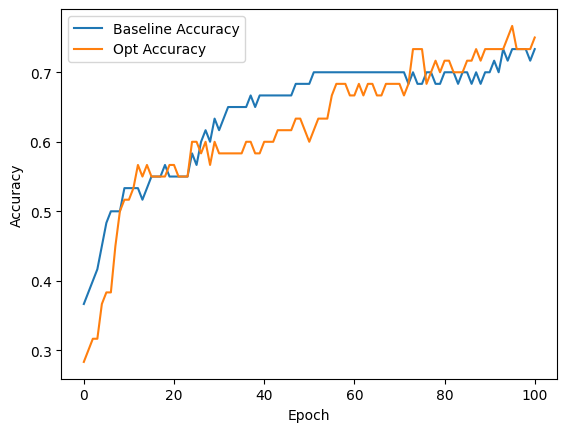

In [81]:
layer_sizes = [10, 32, 16, 3]
step_size = 0.01

key = random.PRNGKey(seed)

keys = random.split(key, 2)

#base model
params_base = init_model(layer_sizes, keys[0])

#adam model
params_opt = init_model(layer_sizes, keys[1])
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params_opt)


base_train = []
base_test = []
base_loss = []
opt_train = []
opt_test = []
opt_loss = []

batch_size = 32
num_epochs = 101
main_key = random.key(seed)


#training loop
for epoch in range(num_epochs):

    main_key, subkey = jax.random.split(main_key)

    for x_batch, y_batch in get_batches(X_train, y_train_oh, batch_size, subkey):
      params_base, dummy, train_loss = update(params_base,  x_batch, y_batch)

    train_acc = accuracy(params_base, X_train, y_train_oh)
    test_acc = accuracy(params_base, X_test, y_test_oh)
    train_loss = loss(params_base, X_train, y_train_oh)

    base_train.append(train_acc)
    base_test.append(test_acc)
    base_loss.append(train_loss)

    if epoch % 10 == 0:
      print(f"Epoch {epoch:03d}: BASE Train Acc = {train_acc:.4f}, BASE Test Acc = {test_acc:.4f}, BASE Loss = {train_loss:.4f}")

    for x_batch, y_batch in get_batches(X_train, y_train_oh, batch_size, subkey):
      params_opt, opt_state, train_loss = update(params_opt, x_batch, y_batch, opt_state)

    train_acc = accuracy(params_opt, X_train, y_train_oh)
    test_acc = accuracy(params_opt, X_test, y_test_oh)
    train_loss = loss(params_opt, X_train, y_train_oh)

    opt_train.append(train_acc)
    opt_test.append(test_acc)
    opt_loss.append(train_loss)


    if epoch % 10 == 0:
      print(f"Epoch {epoch:03d}: OPT Train Acc = {train_acc:.4f}, OPT Test Acc = {test_acc:.4f}, OPT Loss = {train_loss:.4f}")

plt.plot(range(num_epochs), base_test, label = "Baseline Accuracy")

plt.plot(range(num_epochs), opt_test, label = "Opt Accuracy")


plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

As expected, the baseline model converges faster, owing its step size of 0.01 > 0.001, the learning rate of our optimizer. However the optimizer surpasses it using momentum to escape local minima.

Now lets compare their performance with ESGD. First we need a population of models to coevolve.

In [84]:
population_size = 20
key = random.PRNGKey(seed)

keys = random.split(key, population_size + 3)

#base model
params_base = init_model(layer_sizes, keys[0])

#adam model
params_opt = init_model(layer_sizes, keys[1])
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params_opt)

#population of models
population = []
pop_states = []

for i in range(population_size):
  population.append(
  init_model(layer_sizes, keys[i+2]))
  if i%2==0:
    pop_states.append(optimizer.init(population[i])) #half with adam
  else:
    pop_states.append(None) #half without


Half of our population will use base SGD and the other half use the optimizer so that we get the benefits of both (faster initial progress and capability to escape local minima). This is analagous to Heterogeneity.

#Selection
Selection is described in the paper as follows:
1. the top rho individuals in the population comprise 60% of the gene pool
2. the remaining 40% are randomly selected, where their chance of being selected is proportional to their performance

In [47]:
def selection(population, test_accuracies, rho, rng):

    combined = list(zip(test_accuracies, population))

    ranked_combined = sorted(combined, key=lambda x: x[0])

    # Extract the sorted population
    ranked_population = [model for _, model in ranked_combined]
    ranked_accuracies = [acc for acc, _ in ranked_combined]

    top_rho, rest = ranked_population[-rho:], ranked_population[:-rho]
    probabilities = ranked_accuracies[:-rho]

    choices = random.choice(rng, jnp.arange(len(rest)), shape=(len(rest)//2, 1), replace=True, p=jnp.array(probabilities))

    num_parents = len(population)
    top_ratio = 0.6
    num_top = int(top_ratio * num_parents)
    top_repeats = num_top // len(top_rho)

    parents = top_rho * top_repeats + [rest[choice[0]] for choice in choices]

    return parents

#Recombination
The recombination and mutation steps are defined as follows:

\begin{equation}
\theta_i^{(k)} = \frac{1}{\rho} \sum_{j=1}^{\rho} \theta_j^{(k)} + \epsilon_i^{(k)}
\end{equation}

where $\theta_i \in \Psi_\lambda^{(k)}$ (offspring population), $\theta_j \in \Psi_\mu^{(k)}$ (parent population) and $\epsilon_i^{(k)} \sim \mathcal{N}(0, \sigma_k^2)$. An annealing schedule may be applied to $\sigma_k$

This defines the offsprings' parameters as an average of the best performing parents and then adds some noise to represent mutation.

In [48]:
def average_population(population):
    n_models = len(population)

    # Transpose: layers → [(w1_from_all), (b1_from_all)], [(w2_from_all), ...]
    transposed = list(zip(*population))

    avg_model = []
    for layer_params in transposed:
        # layer_params = [(w1, b1), (w2, b2), ..., (wn, bn)] for this layer
        ws, bs = zip(*layer_params)
        avg_w = sum(ws) / n_models
        avg_b = sum(bs) / n_models
        avg_model.append((avg_w, avg_b))

    return avg_model

#Mutation
The Mutation step also makes use of model backoff, where if a mutation leads to a degrade in performance, the equivalent index model from the previous population is kept instead.

In [71]:
def mutation(template, population, test_accuracies, rng, epoch, init_strength = 0.01):

    offspring = [ [(w.copy(), b.copy()) for w, b in template] for _ in range(len(population)) ]

    mutated_offspring = []
    opt_states = []

    total_layers = len(offspring[0])
    keys = random.split(rng, len(offspring) * total_layers * 2)
    key_idx = 0

    strength = init_strength/(epoch+1) #annealing schedule

    backoff = 0

    for idx in range(len(offspring)):

        new_model = []
        for w, b in offspring[idx]:
            kw, kb = keys[key_idx], keys[key_idx + 1]
            key_idx += 2

            #mask to limit the number of parameters mutated to avoid corrupting performance
            mask_w = random.bernoulli(kw, p=0.2, shape=w.shape)  # 10% of weights
            kw, subkey = random.split(kw)
            noise_w = strength * random.normal(subkey, shape=w.shape) * mask_w

            mask_b = random.bernoulli(kb, p=0.2, shape=b.shape)  # 10% of biases
            kb, subkey = random.split(kb)
            noise_b = strength * random.normal(kb, shape=b.shape)  * mask_b
            new_model.append((w + noise_w, b + noise_b))

        if accuracy(new_model, X_test, y_test_oh) < test_accuracies[idx] - 0.1: #margin to avoid backing off too frequently
          backoff += 1
          new_model = population[idx] #use parent if accuracy degrades

        mutated_offspring.append(new_model)

        if idx%2==0:
          opt_states.append(optimizer.init(mutated_offspring[idx]))
        else:
          opt_states.append(None)

    return mutated_offspring, opt_states, backoff

Lets combine these steps into one function that advances our population to the next generation

In [50]:
def advance(population, rng, test_accuracies, rho, epoch):

    parents = selection(population, test_accuracies, rho, rng)

    template = average_population(parents)

    offspring = [ [(w.copy(), b.copy()) for w, b in template] for _ in range(len(population)) ]

    return mutation(template, population, test_accuracies, rng, epoch)


The selection step means the population will give more weight to the gradient descent routes followed by the best performers. Averaging this population will cause the models to converge and if the population is spread evenly over the parameter space, should converge towards the global minimum. Mutation maintains genetic diversity so that the algorithm can effectively "hedge its bets" at the best route to take and helps avoid getting trapped in local minima.

Now lets train the models in parallel and observe the results

Epoch 000: BASE Train Acc = 0.8000, BASE Test Acc = 0.6667, BASE Loss = 0.5761
Finished in 0.004055023193359375
Epoch 000: OPT Train Acc = 0.7571, OPT Test Acc = 0.5667, OPT Loss = 0.5956
Finished in 0.00635838508605957
Epoch 000: Pop max Train Acc = 0.7786, Pop max Test Acc = 0.6833, Pop min Loss = 0.6157
Finished in 0.388995885848999


Epoch 010: BASE Train Acc = 0.8143, BASE Test Acc = 0.6500, BASE Loss = 0.5374
Finished in 0.002884387969970703
Epoch 010: OPT Train Acc = 0.7714, OPT Test Acc = 0.5833, OPT Loss = 0.5415
Finished in 0.004196882247924805
Epoch 010: Pop max Train Acc = 0.8000, Pop max Test Acc = 0.7000, Pop min Loss = 0.5474
Finished in 0.31742334365844727


Epoch 020: BASE Train Acc = 0.8000, BASE Test Acc = 0.6500, BASE Loss = 0.4943
Finished in 0.003459453582763672
Epoch 020: OPT Train Acc = 0.8000, OPT Test Acc = 0.6000, OPT Loss = 0.4991
Finished in 0.004286527633666992
Epoch 020: Pop max Train Acc = 0.8000, Pop max Test Acc = 0.7000, Pop min Loss = 0.4987
Finished

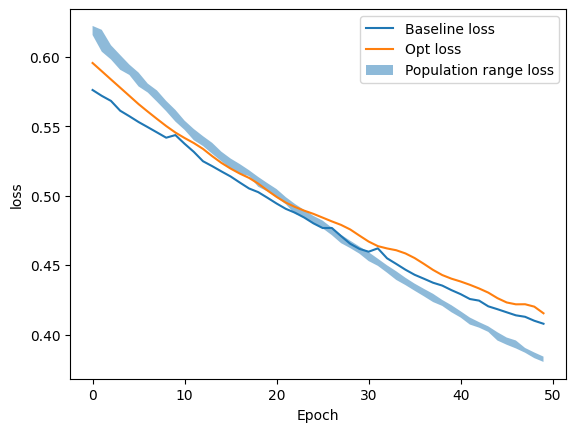

In [86]:

batch_size = 64
num_epochs = 50

base_train = []
base_test = []
base_loss = []

opt_train = []
opt_test = []
opt_loss = []

pop_train = []
pop_test = []
pop_loss = []

backoff = []

for epoch in range(num_epochs):

    main_key, subkey = jax.random.split(main_key)

    start_time = time.time()


    for x_batch, y_batch in get_batches(X_train, y_train_oh, batch_size, subkey):
      params_base, dummy, train_loss = update(params_base,  x_batch, y_batch)

    epoch_time = time.time() - start_time

    train_acc = accuracy(params_base, X_train, y_train_oh)
    test_acc = accuracy(params_base, X_test, y_test_oh)
    train_loss = loss(params_base, X_train, y_train_oh)

    base_train.append(train_acc)
    base_test.append(test_acc)
    base_loss.append(train_loss)

    if epoch % 10 == 0:
      print(f"Epoch {epoch:03d}: BASE Train Acc = {train_acc:.4f}, BASE Test Acc = {test_acc:.4f}, BASE Loss = {train_loss:.4f}")
      print(f"Finished in {epoch_time}")

    start_time = time.time()

    for x_batch, y_batch in get_batches(X_train, y_train_oh, batch_size, subkey):
      params_opt, opt_state, train_loss = update(params_opt, x_batch, y_batch, opt_state)

    epoch_time = time.time() - start_time

    train_acc = accuracy(params_opt, X_train, y_train_oh)
    test_acc = accuracy(params_opt, X_test, y_test_oh)
    train_loss = loss(params_opt, X_train, y_train_oh)

    opt_train.append(train_acc)
    opt_test.append(test_acc)
    opt_loss.append(train_loss)

    if epoch % 10 == 0:
      print(f"Epoch {epoch:03d}: OPT Train Acc = {train_acc:.4f}, OPT Test Acc = {test_acc:.4f}, OPT Loss = {train_loss:.4f}")
      print(f"Finished in {epoch_time}")

    pop_accs = []
    ind_loss = []


    new_population = []
    new_pop_states = []

    start_time = time.time()

    for species, opt_state_ in zip(population, pop_states):
        for x_batch, y_batch in get_batches(X_train, y_train_oh, batch_size, subkey):
            species, opt_state_, train_loss = update(species, x_batch, y_batch, opt_state_)

        train_acc = accuracy(species, X_train, y_train_oh)
        test_acc = accuracy(species, X_test, y_test_oh)
        train_loss = loss(species, X_train, y_train_oh)

        pop_accs.append((train_acc, test_acc))
        ind_loss.append(train_loss)

        new_population.append(species)
        new_pop_states.append(opt_state_)

    pop_loss.append((max(ind_loss), min(ind_loss)))
    population = new_population
    pop_states = new_pop_states




    pop_train.append((max([x[0] for x in pop_accs]), min([x[0] for x in pop_accs])))
    pop_test.append((max([x[1] for x in pop_accs]), min([x[1] for x in pop_accs])))

    population, pop_states, backoffs = advance(population, random.key(epoch), [x[1] for x in pop_accs], 10, epoch)

    epoch_time = time.time() - start_time

    backoff.append(backoffs)

    if epoch % 10 == 0:
      print(f"Epoch {epoch:03d}: Pop max Train Acc = {max([x[0] for x in pop_accs]):.4f}, Pop max Test Acc = {max([x[1] for x in pop_accs]):.4f}, Pop min Loss = {min(ind_loss):.4f}")
      print(f"Finished in {epoch_time}")
      print("\n")


plt.plot(range(num_epochs), base_loss, label = "Baseline loss")

plt.plot(range(num_epochs), opt_loss, label = "Opt loss")

plt.fill_between(range(num_epochs), [x[0] for x in pop_loss], [x[1] for x in pop_loss], alpha=0.5, label='Population range loss')

plt.xlabel("Epoch")
plt.ylabel("loss")
#plt.ylim(0, 0.5)
plt.legend()
plt.show()

This time the models' loss has been plotted and the population has been plotted as a band ranging from its best to worst performer at a given epoch. It is clear that at an evolutionary search can give rise to a much steeper descent of the loss function.

Lets now plot the number o

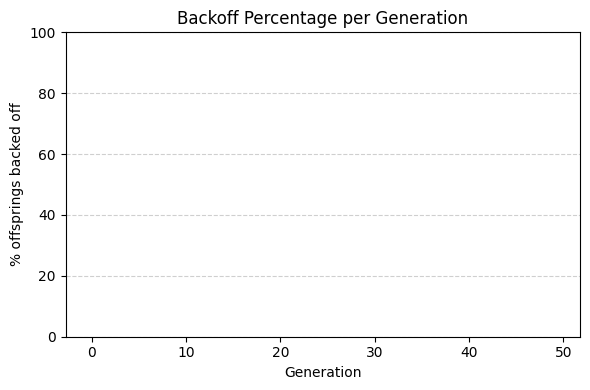

In [88]:
generations = list(range(len(backoff)))
backoff_percent = [100 * b / population_size for b in backoff]

#print(backoff)

plt.figure(figsize=(6, 4))
plt.bar(generations, backoff_percent, color='gray', width=0.6)

plt.xlabel("Generation")
plt.ylabel("% offsprings backed off")
plt.title("Backoff Percentage per Generation")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

This graph shows the percentage of models backed off to the previous generation at each epoch. Hyperparameters need tuning to produce results like those in the paper.

Experimenting with a toy model of ESGD has demonstrated its potential to enhance performance optimization when used alongside gradient descent methods, while also highlighting its substantial increase in memory usage and compute time. The algorithm also suffers from over-hyperparameterisation meaning an extensive grid search may be required for a given problem.